In [10]:
# Installation des packages nécessaires
!pip install earthengine-api geemap geopandas

# Imports
import ee
import geemap
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Authentification GEE (première fois uniquement)
ee.Authenticate()

# Initialisation
ee.Initialize(project='rosy-algebra-476610-q7')

print("✅ Earth Engine initialisé avec succès!")

✅ Earth Engine initialisé avec succès!


📤 Uploader votre fichier GADM (shapefile)...


Saving gadm41_SEN_2.cpg to gadm41_SEN_2 (1).cpg
Saving gadm41_SEN_2.dbf to gadm41_SEN_2 (1).dbf
Saving gadm41_SEN_2.prj to gadm41_SEN_2 (1).prj
Saving gadm41_SEN_2.shp to gadm41_SEN_2 (1).shp
Saving gadm41_SEN_2.shx to gadm41_SEN_2 (1).shx

 Chargement de: gadm41_SEN_2 (1).shp

📊 APERÇU DES DONNÉES:
       GID_2 GID_0  COUNTRY    GID_1    NAME_1 NL_NAME_1      NAME_2  \
0  SEN.1.1_1   SEN  Senegal  SEN.1_1     Dakar        NA       Dakar   
1  SEN.1.2_1   SEN  Senegal  SEN.1_1     Dakar        NA  Guédiawaye   
2  SEN.1.3_1   SEN  Senegal  SEN.1_1     Dakar        NA      Pikine   
3  SEN.1.4_1   SEN  Senegal  SEN.1_1     Dakar        NA    Rufisque   
4  SEN.2.1_1   SEN  Senegal  SEN.2_1  Diourbel        NA      Bambey   

         VARNAME_2 NL_NAME_2       TYPE_2   ENGTYPE_2 CC_2    HASC_2  \
0               NA        NA  Département  Department   11  SN.DK.DK   
1               NA        NA  Département  Department   14  SN.DK.GD   
2               NA        NA  Département  Departm

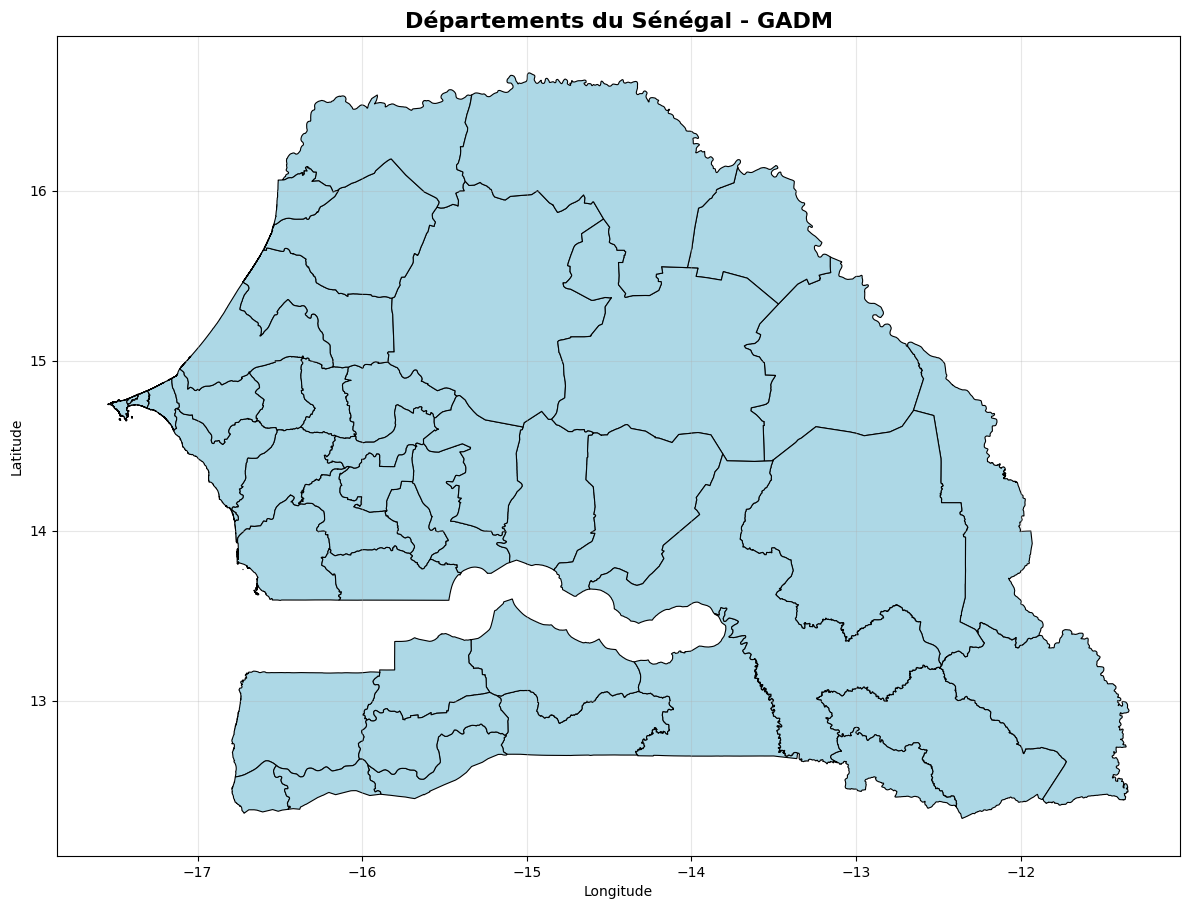


✅ Données GADM chargées avec succès!


In [11]:
from google.colab import files
import geopandas as gpd
import matplotlib.pyplot as plt

# Uploader vos fichiers
print("📤 Uploader votre fichier GADM (shapefile)...")
uploaded = files.upload()

# CORRECTION : Trouver spécifiquement le fichier .shp
shp_file = [f for f in uploaded.keys() if f.endswith('.shp')][0]

print(f"\n Chargement de: {shp_file}")

# Charger le shapefile
senegal_dept = gpd.read_file(shp_file)

# Vérifier les données
print("\n APERÇU DES DONNÉES:")
print(senegal_dept.head())
print(f"\n Nombre de départements: {len(senegal_dept)}")
print(f"\n Colonnes disponibles:")
print(senegal_dept.columns.tolist())

# Vérifier le système de coordonnées
print(f"\n Système de coordonnées: {senegal_dept.crs}")

# S'assurer que le CRS est en WGS84 (EPSG:4326)
if senegal_dept.crs != 'EPSG:4326':
    print(" Conversion en EPSG:4326...")
    senegal_dept = senegal_dept.to_crs('EPSG:4326')
    print("✅ Conversion terminée!")

# Visualiser
fig, ax = plt.subplots(figsize=(12, 10))
senegal_dept.plot(ax=ax, edgecolor='black', facecolor='lightblue', linewidth=0.8)
plt.title('Départements du Sénégal - GADM', fontsize=16, fontweight='bold')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Données GADM chargées avec succès!")

In [12]:
# Convertir le GeoDataFrame en GeoJSON
senegal_geojson = senegal_dept.__geo_interface__

# Créer une FeatureCollection Earth Engine
senegal_fc = ee.FeatureCollection(senegal_geojson)

# Vérifier
print(f"✅ FeatureCollection créée avec {senegal_fc.size().getInfo()} départements")

# Obtenir les limites globales
bounds = senegal_fc.geometry().bounds()
print("\n Limites du Sénégal:", bounds.getInfo()['coordinates'])

✅ FeatureCollection créée avec 45 départements

 Limites du Sénégal: [[[-17.543185999999935, 12.307859420000087], [-11.342470169999899, 12.307859420000087], [-11.342470169999899, 16.69207191600011], [-17.543185999999935, 16.69207191600011], [-17.543185999999935, 12.307859420000087]]]


In [13]:
# Définir la période d'étude - ANNÉE 2018
start_date = '2018-01-01'
end_date = '2018-12-31'

print(f" Période d'analyse: {start_date} à {end_date}")

# Charger la collection Sentinel-2 Surface Reflectance
print("\n Chargement des images Sentinel-2...")
sentinel2 = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED') \
    .filterBounds(senegal_fc) \
    .filterDate(start_date, end_date) \
    .select(['B4', 'B8'])  # Rouge et NIR

# Afficher le nombre d'images disponibles
n_images = sentinel2.size().getInfo()
print(f" Nombre d'images disponibles: {n_images}")

if n_images == 0:
    print(" Aucune image trouvée. Vérifiez les dates ou la zone.")
else:
    print(f"✅ {n_images} images chargées avec succès!")
    print("\n Bandes sélectionnées:")
    print("  - Bande Rouge (B4): 665 nm")
    print("  - Bande NIR (B8): 842 nm")
    print("\n Prêt pour la vérification des propriétés et le calcul du BAI!")

📅 Période d'analyse: 2018-01-01 à 2018-12-31

⏳ Chargement des images Sentinel-2...
🛰️ Nombre d'images disponibles: 467
✅ 467 images chargées avec succès!

 Bandes sélectionnées:
  - Bande Rouge (B4): 665 nm
  - Bande NIR (B8): 842 nm

💡 Prêt pour la vérification des propriétés et le calcul du BAI!


In [14]:

  # Vérification des propriétés des bandes R et NIR
print("=" * 70)
print("🔍 PROPRIÉTÉS DES BANDES ROUGE (B4) ET NIR (B8)")
print("=" * 70)

# Prendre une image exemple de la collection
sample_image = sentinel2.first()

# Propriétés de la bande Rouge (B4)
print("\n🔴 BANDE ROUGE (B4):")
red_projection = sample_image.select('B4').projection()
print(f" Projection: {red_projection.crs().getInfo()}")
print(f" Résolution spatiale: {red_projection.nominalScale().getInfo()} mètres")
print(f" Longueur d'onde: 665 nm (visible rouge)")

# Propriétés de la bande NIR (B8)
print("\n🟢 BANDE NIR (B8):")
nir_projection = sample_image.select('B8').projection()
print(f" Projection: {nir_projection.crs().getInfo()}")
print(f" Résolution spatiale: {nir_projection.nominalScale().getInfo()} mètres")
print(f" Longueur d'onde: 842 nm (proche infrarouge)")

# Informations générales
print("\n INFORMATIONS GÉNÉRALES:")
print(f"  Période: {start_date} à {end_date}")
print(f"  Nombre d'images: {n_images}")
print(f"  Zone: Sénégal")


# Emprise spatiale
bounds = senegal_fc.geometry().bounds().coordinates().getInfo()
print(f"\n EMPRISE GÉOGRAPHIQUE:")
print(f"  Limites: {bounds[0][:2]} (Sud-Ouest) à {bounds[0][2:4]} (Nord-Est)")

print("\n" + "=" * 70)
print("✅ PROPRIÉTÉS VÉRIFIÉES - PRÊT POUR LE CALCUL DU BAI")
print("=" * 70)

🔍 PROPRIÉTÉS DES BANDES ROUGE (B4) ET NIR (B8)

🔴 BANDE ROUGE (B4):
  📐 Projection: EPSG:32628
  📏 Résolution spatiale: 10 mètres
  🌊 Longueur d'onde: 665 nm (visible rouge)

🟢 BANDE NIR (B8):
  📐 Projection: EPSG:32628
  📏 Résolution spatiale: 10 mètres
  🌊 Longueur d'onde: 842 nm (proche infrarouge)

 INFORMATIONS GÉNÉRALES:
  Période: 2018-01-01 à 2018-12-31
  Nombre d'images: 467
  Zone: Sénégal

 EMPRISE GÉOGRAPHIQUE:
  Limites: [[-17.543185999999935, 12.307859420000087], [-11.342470169999899, 12.307859420000087]] (Sud-Ouest) à [[-11.342470169999899, 16.69207191600011], [-17.543185999999935, 16.69207191600011]] (Nord-Est)

✅ PROPRIÉTÉS VÉRIFIÉES - PRÊT POUR LE CALCUL DU BAI


In [16]:
# ============================================================================
# CALCUL DU BAI AVEC MASQUE
# Garde : végétation + sols nus avec BAI élevé (probablement brûlés)
# Exclut : eau + infrastructures urbaines
# ============================================================================

def calculate_bai_mask(image):
    """
    BAI avec masque :
    - Végétation toujours incluse
    - Sol nu inclus UNIQUEMENT si BAI élevé
    - Eau et zones urbaines exclues
    """

    # Normalisation Sentinel-2
    red = image.select('B4').divide(10000)
    nir = image.select('B8').divide(10000)

    # Occupation du sol
    landcover = ee.ImageCollection("ESA/WorldCover/v200").first()

    # --------------------------
    # Calcul du BAI
    # --------------------------
    bai = ee.Image(1.0).divide(
        ee.Image(0.1).subtract(red).pow(2).add(
            ee.Image(0.06).subtract(nir).pow(2)
        )
    ).rename('BAI')

    # --------------------------
    # Masque végétation
    # --------------------------
    vegetation_mask = (
        landcover.eq(10)   # Arbres
        .Or(landcover.eq(20))   # Arbustes
        .Or(landcover.eq(30))   # Prairies
        .Or(landcover.eq(40))   # Cultures
        .Or(landcover.eq(90))   # Zones humides
        .Or(landcover.eq(95))   # Mangroves
    )

    # --------------------------
    # Sol nu brûlé probable
    # --------------------------
    bare_soil = landcover.eq(60)
    high_bai = bai.gt(50)
    bare_soil_burned = bare_soil.And(high_bai)

    # --------------------------
    # Masque final
    # --------------------------
    final_mask = vegetation_mask.Or(bare_soil_burned)

    # Appliquer le masque
    bai_masked = bai.updateMask(final_mask)

    return bai_masked.copyProperties(image, ['system:time_start'])

# ============================================================================
# APPLICATION
# ============================================================================

print("=" * 70)
print(" CALCUL DU BAI AVEC MASQUE ")
print("=" * 70)

print("\n📋 SURFACES GARDÉES :")
print("   ✅ Toute la végétation (arbres, arbustes, prairies, cultures)")
print("   ✅ Sols nus avec BAI > 50 (zones potentiellement brûlées)")

print("\n📋 SURFACES EXCLUES :")
print("   ❌ Eau (océan, rivières, lacs)")
print("   ❌ Zones urbaines (bâtiments, routes)")
print("   ❌ Sols nus avec BAI faible (désert naturel, plages)")

print(f"\n Traitement de {n_images} images...")

# Appliquer le calcul
bai_collection = sentinel2.map(calculate_bai_mask)
bai_image = bai_collection.mean().rename('BAI')

print("\n✅ BAI calculé avec succès!")
print("\n Note : Les sols nus sont inclus UNIQUEMENT si BAI > 50")
print("   (indiquant une probable zone brûlée récente)")
print("=" * 70)

⏳ CALCUL DU BAI AVEC MASQUE INTELLIGENT

📋 SURFACES GARDÉES :
   ✅ Toute la végétation (arbres, arbustes, prairies, cultures)
   ✅ Sols nus avec BAI > 50 (zones potentiellement brûlées)

📋 SURFACES EXCLUES :
   ❌ Eau (océan, rivières, lacs)
   ❌ Zones urbaines (bâtiments, routes)
   ❌ Sols nus avec BAI faible (désert naturel, plages)

⏳ Traitement de 467 images...

✅ BAI calculé avec succès!

💡 Note : Les sols nus sont inclus UNIQUEMENT si BAI > 50
   (indiquant une probable zone brûlée récente)


In [17]:
# ============================================================================
# AGRÉGATION PAR DÉPARTEMENT - MOYENNE DU BAI
# ============================================================================

# Fonction SIMPLIFIÉE pour calculer la MOYENNE du BAI par département
def add_bai_mean(feature):
    """
    Calcule la MOYENNE du BAI pour chaque département
    """
    # Calculer uniquement la moyenne
    stats = bai_image.reduceRegion(
        reducer=ee.Reducer.mean(),  # Seulement la moyenne
        geometry=feature.geometry(),
        scale=100,  # Résolution 100m
        maxPixels=1e13,
        bestEffort=True,
        tileScale=4
    )

    return feature.set(stats)

# Appliquer la fonction à tous les départements
print("=" * 70)
print("⏳ CALCUL DE LA MOYENNE DU BAI PAR DÉPARTEMENT")
print("=" * 70)
print(f"\n Nombre de départements: {senegal_fc.size().getInfo()}")
print(f" Période: {start_date} à {end_date}")
print(f" Images utilisées: {n_images}")
print("\n Traitement en cours...\n")

try:
    bai_by_dept = senegal_fc.map(add_bai_mean)
    print("✅ Agrégation terminée!")

except Exception as e:
    print(f"❌ Erreur: {e}")
    bai_by_dept = None

# ============================================================================
# CONVERSION EN DATAFRAME ET INTERPRÉTATION
# ============================================================================

def fc_to_dataframe_simple(fc):
    """Convertir FeatureCollection en DataFrame"""
    try:
        print("⏳ Récupération des données...")
        features = fc.getInfo()['features']

        data = []
        for feature in features:
            props = feature['properties']
            data.append(props)

        print(f"✅ {len(data)} départements récupérés")
        return pd.DataFrame(data)

    except Exception as e:
        print(f"❌ Erreur: {e}")
        return None

# Créer le DataFrame
if bai_by_dept is not None:
    df_bai = fc_to_dataframe_simple(bai_by_dept)

    if df_bai is not None:
        print("\n" + "=" * 70)
        print(" TRAITEMENT DES DONNÉES")
        print("=" * 70)

        # Identifier la colonne du nom du département
        dept_name_col = None
        for col in ['NAME_2', 'NAME_1', 'VARNAME_2', 'GID_2']:
            if col in df_bai.columns:
                dept_name_col = col
                break

        if dept_name_col is None:
            print("⚠️ Colonne département non trouvée, utilisation de l'index")
            df_bai['Departement'] = df_bai.index
        else:
            df_bai['Departement'] = df_bai[dept_name_col]

        # Renommer la colonne BAI
        df_bai = df_bai.rename(columns={'BAI': 'BAI_moyen'})

        # Fonction d'interprétation du BAI
        def interpreter_bai(bai_value):
            """
            Interprète la valeur du BAI
            """
            if pd.isna(bai_value):
                return "Données manquantes"
            elif bai_value < 10:
                return "Non brûlé"
            elif bai_value < 50:
                return "Végétation sèche"
            elif bai_value < 150:
                return "Zones brûlées probables"
            else:
                return "Brûlé"

        # Appliquer l'interprétation
        print("\n⏳ Application de l'interprétation du BAI...")
        df_bai['Interpretation'] = df_bai['BAI_moyen'].apply(interpreter_bai)

        # Créer le DataFrame final avec seulement les colonnes nécessaires
        df_final = df_bai[['Departement', 'BAI_moyen', 'Interpretation']].copy()

        # Arrondir les valeurs BAI
        df_final['BAI_moyen'] = df_final['BAI_moyen'].round(4)

        # Trier par BAI décroissant
        df_final = df_final.sort_values('BAI_moyen', ascending=False).reset_index(drop=True)

        print("✅ Interprétation appliquée!")

        # ====================================================================
        # AFFICHAGE DES RÉSULTATS
        # ====================================================================

        print("\n" + "=" * 70)
        print("📋 RÉSULTATS FINAUX - BAI PAR DÉPARTEMENT")
        print("=" * 70)

        print("\n📊 Aperçu du DataFrame final:")
        print(df_final.head(15))

        print(f"\n📈 STATISTIQUES:")
        print(f"  - Nombre de départements: {len(df_final)}")
        print(f"  - BAI moyen global: {df_final['BAI_moyen'].mean():.4f}")
        print(f"  - BAI médian: {df_final['BAI_moyen'].median():.4f}")
        print(f"  - BAI minimum: {df_final['BAI_moyen'].min():.4f}")
        print(f"  - BAI maximum: {df_final['BAI_moyen'].max():.4f}")

        # Répartition par catégorie
        print("\n🔥 RÉPARTITION PAR CATÉGORIE:")
        repartition = df_final['Interpretation'].value_counts()
        for categorie, count in repartition.items():
            pourcentage = (count / len(df_final)) * 100
            print(f"  - {categorie}: {count} départements ({pourcentage:.1f}%)")

        # Top 5 départements les plus brûlés
        print("\n🔥 TOP 5 DÉPARTEMENTS AVEC BAI LE PLUS ÉLEVÉ:")
        for idx, row in df_final.head(5).iterrows():
            print(f"  {idx+1}. {row['Departement']}: {row['BAI_moyen']:.4f} ({row['Interpretation']})")

        # Top 5 départements les moins brûlés
        print("\n🌿 TOP 5 DÉPARTEMENTS AVEC BAI LE PLUS FAIBLE:")
        bottom5 = df_final.tail(5).sort_values('BAI_moyen')
        for idx, row in bottom5.iterrows():
            print(f"  - {row['Departement']}: {row['BAI_moyen']:.4f} ({row['Interpretation']})")

        # ====================================================================
        # EXPORT VERS GOOGLE DRIVE
        # ====================================================================

        print("\n" + "=" * 70)
        print("💾 EXPORT VERS GOOGLE DRIVE")
        print("=" * 70)

        # Monter Google Drive
        try:
            from google.colab import drive
            drive.mount('/content/drive', force_remount=False)
            print("✅ Google Drive monté")

            # Nom du fichier avec date
            from datetime import datetime
            date_now = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f'bai_senegal_departements_2018_{date_now}.csv'

            # Chemin d'export
            export_path = f'/content/drive/MyDrive/{filename}'

            # Exporter
            df_final.to_csv(export_path, index=False, encoding='utf-8-sig')

            print(f"✅ Fichier exporté avec succès!")
            print(f"📁 Chemin: MyDrive/{filename}")
            print(f"📊 {len(df_final)} départements exportés")

        except Exception as e:
            print(f"⚠️ Erreur lors de l'export vers Drive: {e}")
            print("\n💡 Export local en cours...")

            # Export local en cas d'échec Drive
            local_filename = f'bai_senegal_departements_2018.csv'
            df_final.to_csv(local_filename, index=False, encoding='utf-8-sig')
            print(f"✅ Fichier exporté localement: {local_filename}")

            # Télécharger
            try:
                from google.colab import files
                files.download(local_filename)
                print("✅ Téléchargement lancé")
            except:
                print("💡 Fichier disponible dans l'arborescence de Colab")

        print("\n" + "=" * 70)
        print("✅ TRAITEMENT TERMINÉ AVEC SUCCÈS!")
        print("=" * 70)

        # Variable globale pour utilisation ultérieure
        print(f"\n💡 Le DataFrame est disponible dans la variable: df_final")

    else:
        print("❌ Impossible de créer le DataFrame")
        df_final = None
else:
    print("❌ Pas de données à traiter")
    df_final = None


⏳ CALCUL DE LA MOYENNE DU BAI PAR DÉPARTEMENT

📍 Nombre de départements: 45
📅 Période: 2018-01-01 à 2018-12-31
🛰️ Images utilisées: 467

⏳ Traitement en cours...

✅ Agrégation terminée!
⏳ Récupération des données...
✅ 45 départements récupérés

📊 TRAITEMENT DES DONNÉES

⏳ Application de l'interprétation du BAI...
✅ Interprétation appliquée!

📋 RÉSULTATS FINAUX - BAI PAR DÉPARTEMENT

📊 Aperçu du DataFrame final:
    Departement  BAI_moyen           Interpretation
0      Oussouye    83.8124  Zones brûlées probables
1        Saraya    62.8045  Zones brûlées probables
2      Kédougou    56.9114  Zones brûlées probables
3      Salémata    52.3954  Zones brûlées probables
4        Pikine    48.5536         Végétation sèche
5         Bakel    48.4100         Végétation sèche
6       Bignona    42.7544         Végétation sèche
7    Ziguinchor    40.0809         Végétation sèche
8   Tambacounda    39.7735         Végétation sèche
9         Dakar    39.5313         Végétation sèche
10  Foundioug